In [1]:
# Packages to import 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree

Here I try to replicate the following data generating process:
    
$y = -0.5x + 100 + \epsilon$ if x <= -10;

$y = -15 + \epsilon$ if -10<x<=100; 

$y = 42 + 0.5x + \epsilon$ if x>100;

where $E(\epsilon) = 0$ and $Var(\epsilon)$ = $\sigma^2$


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'e'}>]], dtype=object)

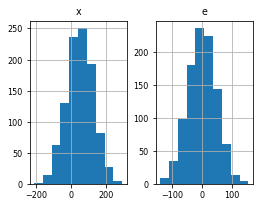

In [2]:
# we start by randomly generating our X's
df = pd.DataFrame(data = np.random.normal(50, 75, (1000, 1)), columns = ['x'])
df['e'] = np.random.normal(0, 50,(1000, 1))
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3)})
df.hist()


In [3]:
# we define conditions to generate Y's
conditions = [
    (df['x'] <= -10),
    ((df['x']>-10) & (df['x'] <= 100)),
    (df['x']>100),
    ]
# create a list of the values we want to assign for each condition
values = [-0.5*df['x']+100, -15, 42+0.5*df['x']]

# create a new column and use np.select to assign values to it using our lists as arguments
df['y'] = np.select(conditions, values)
df['y'] = df['y'] + df['e']
df.head()

,x,e,y
0,25.604224,-57.707198,-72.707198
1,4.849710,1.711141,-13.288859
2,130.871466,23.096697,130.532430
3,63.390034,0.586624,-14.413376
4,35.162662,12.498445,-2.501555


<AxesSubplot:xlabel='x', ylabel='y'>

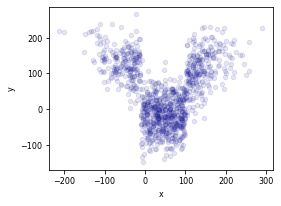

In [4]:
# we observe a non-linear distribution
df.plot.scatter(x='x', y='y', c='DarkBlue', alpha = 0.1)

In [5]:
# adding higher orders of x

for i in range(2,5):
    df[f"x_{i}"] = np.power(df['x'], i)

df.head()

,x,e,y,x_2,x_3,x_4
0,25.604224,-57.707198,-72.707198,655.576280,1.678552e+04,4.297803e+05
1,4.849710,1.711141,-13.288859,23.519692,1.140637e+02,5.531759e+02
2,130.871466,23.096697,130.532430,17127.340508,2.241480e+06,2.933458e+08
3,63.390034,0.586624,-14.413376,4018.296430,2.547199e+05,1.614671e+07
4,35.162662,12.498445,-2.501555,1236.412769,4.347556e+04,1.528717e+06


In [6]:
# we try to build a prediction model using OLS regression

y = df['y'] 
# X = df['x'].values.reshape(-1,1) # reshaping is needed if your X is one-dimensional, as otherwise, the array is read in a row, not in a column

X = df[['x', 'x_2']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # try to use as much training data as possible - 80%/20% or 90%/10%


regr = LinearRegression(fit_intercept = True, copy_X=False, n_jobs=-1) 
regr.fit(X_train, y_train)

# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients:', regr.coef_ )

# Make out-of-sample predictions 
y_pred = regr.predict(X_test)


Intercept: 23.481
Coefficients: [-0.71005165  0.00723289]


Out-of-sample Rsq: 0.462
Out-of-sample MSE: 3694.863


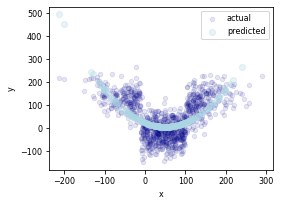

In [7]:
# still not perfect after fitting a quadratic regression

df.plot.scatter(x='x', y='y', c='DarkBlue', alpha = 0.1, label='actual')
plt.scatter(X_test['x'], y_pred, c = 'LightBlue', alpha = 0.3, label='predicted')
plt.legend()

# Out-of-sample R-sq. and mean squared error
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Text(0, 0.5, 'Predicted Y')

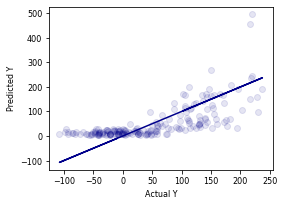

In [8]:
# prediction to the left of the line is not great, but slightly better on the right
plt.scatter(y_test, y_pred, c = 'DarkBlue', alpha = 0.1)
plt.plot(y_test, y_test, c = 'DarkBlue')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')

In [9]:
# we can look into the data and understand it better, but here we know about the discontinuities
# parametric models seem restrictive so we turn to non parametric methods

# We train a Classification and Regression trees (CART) model and check the fit again.

In [10]:
y = df['y'] 
X = df['x'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # try to use as much training data as possible - 80%/20% or 90%/10%

cart = tree.DecisionTreeRegressor()
cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

Out-of-sample Rsq: 0.455
Out-of-sample MSE: 4231.993


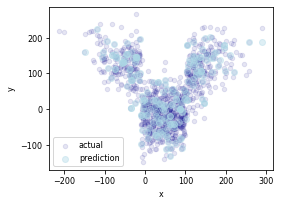

In [11]:
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))
 
df.plot.scatter(x='x', y='y', c='DarkBlue', alpha = 0.1, label = 'actual')
plt.scatter(X_test, y_pred, c = 'LightBlue', alpha = 0.4, label= 'prediction')
plt.legend()

Text(0, 0.5, 'Predicted Y')

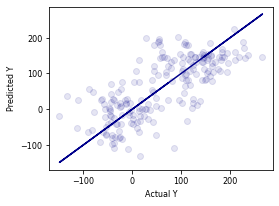

In [12]:
plt.scatter(y_test, y_pred, c = 'DarkBlue', alpha = 0.1)
plt.plot(y_test, y_test, c = 'DarkBlue')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')

Out-of-sample Rsq: 0.715
Out-of-sample MSE: 1958.892


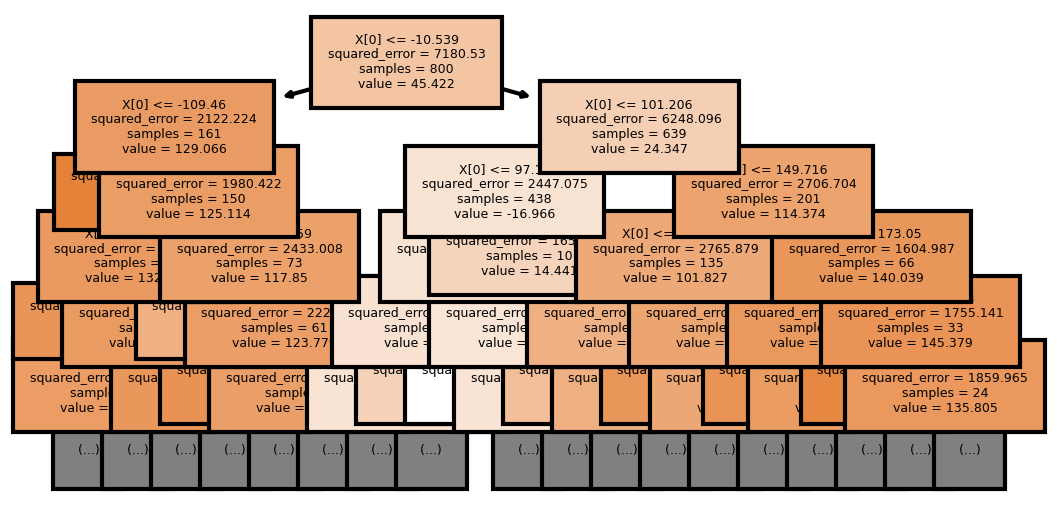

In [13]:
# fitting a tree to the same data
y = df['y'] 
X = df['x'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

# if we don't use a stopping rule, our tree will overfit by picking up too much noise from our training dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html 
cart = tree.DecisionTreeRegressor(criterion='squared_error', min_samples_split =20, min_samples_leaf = 5, min_impurity_decrease = 0, max_depth = 6, random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True,\
               fontsize = 3);

### Example of Prostate Cancer Diagnosis (Taddy 'Business Data Science') 

* We have biopsy data for 97 prostate cancer tumors 
* Aim: build a model to forecast the tumor volume (based on analyses of a patient) and to offer the treatment 
    * lcavol - tumor volume (Y), target
    * age of a patient
    * lbph - size of prostate
    * lcp - reach of tumor into gland lining 
    * gleason -microscopic pattern classes
    * lpsa - protein production 


In [14]:
# Pruning a tree
# source https://github.com/TaddyLab/bds 
df = pd.read_csv(r"C:\Users\johnd\OneDrive\Desktop\ML lecture\lecture6\data\prostate.csv", delimiter = ';')
df.head()

,lcavol,age,lbph,lcp,gleason,lpsa
0,-0.579818,50,-1.386294,-1.386294,6,-0.430783
1,-0.994252,58,-1.386294,-1.386294,6,-0.162519
2,-0.510826,74,-1.386294,-1.386294,7,-0.162519
3,-1.203973,58,-1.386294,-1.386294,6,-0.162519
4,0.751416,62,-1.386294,-1.386294,6,0.371564


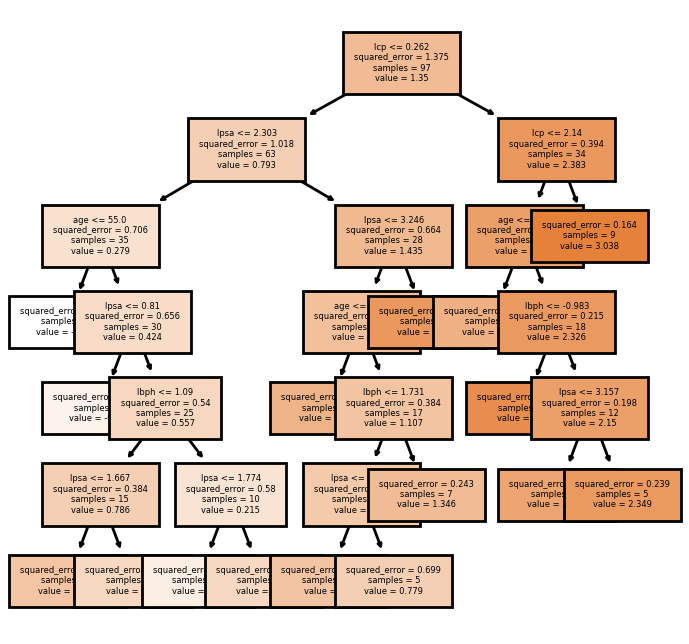

In [15]:
y= df['lcavol']
X= df.iloc[:,1:]

cart = tree.DecisionTreeRegressor(criterion='squared_error', min_samples_split =7, min_samples_leaf = 5, max_depth = 6, random_state = 1)
cart = cart.fit(X, y) #no split as small dataset

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 4), 'figure.dpi': 200})
tree.plot_tree(cart, max_depth = 10, feature_names = list(X.columns), filled = True,\
               fontsize = 3);

In [16]:
# pruning plus cross validation, we pick the model with the lowest mean-squared error.
from sklearn.model_selection import cross_validate
import scipy as sp

# write a function that runs a CV procedure for a candidate model of a given depth (max_depth)
# or of a given number of nodes (max_leaf_nodes). 
# Note: a tree of the same depth could have a different number of nodes, 
# some deeper nodes, which generate the lowest relative reduction in impurity, are removed. 

def cv_iter(max_depth, max_leaf_nodes, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    cart = tree.DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, random_state = 1)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Max leaf nodes'>

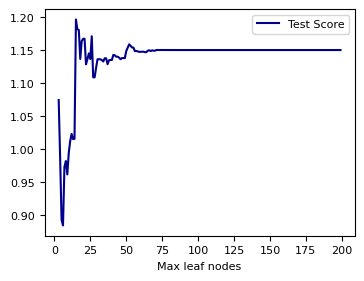

In [17]:
y = df['lcavol'] 
X = df.iloc[:, 1:]

result = {}
for i in range(3, 200):
    result[i] = cv_iter(None, i, 5, X, y) # iterating over the max_leaf_nodes

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Max leaf nodes')

In [18]:
results['Test Score'].idxmin() # so 6 nodes produced lowest mse from our cv results

6

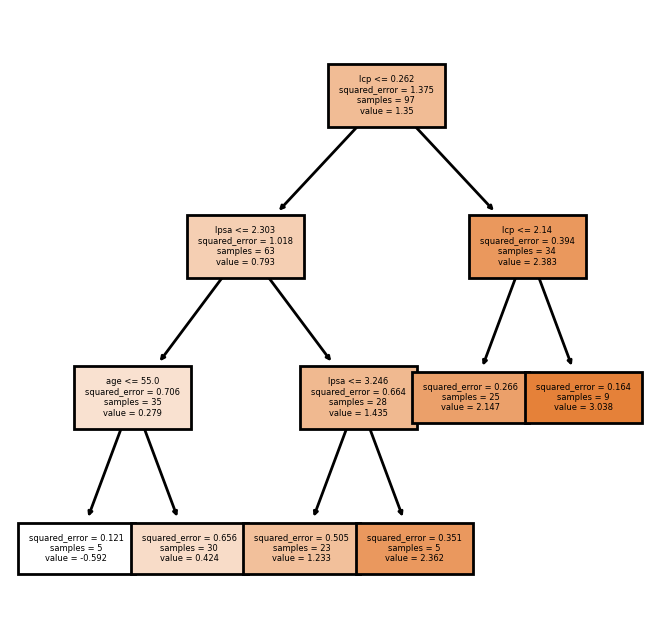

In [19]:
# we use above result of 6 max_leaf_nodes for new tree 
cart = tree.DecisionTreeRegressor(criterion='squared_error', min_samples_split =7, min_samples_leaf = 5, max_leaf_nodes = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X, y) #no split as small dataset

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 4), 'figure.dpi': 200})
tree.plot_tree(cart, feature_names = list(X.columns), filled = True,\
               fontsize = 3);

<AxesSubplot:xlabel='Max depth'>

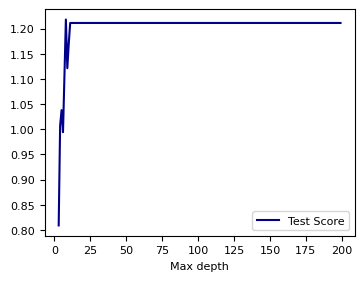

In [20]:
# iterate over max_depth and compare the result. 

result = {}
for i in range(3, 200):
    result[i] = cv_iter(i, None, 5, X, y) 

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Max depth')

In [21]:
results['Test Score'].idxmin()

3

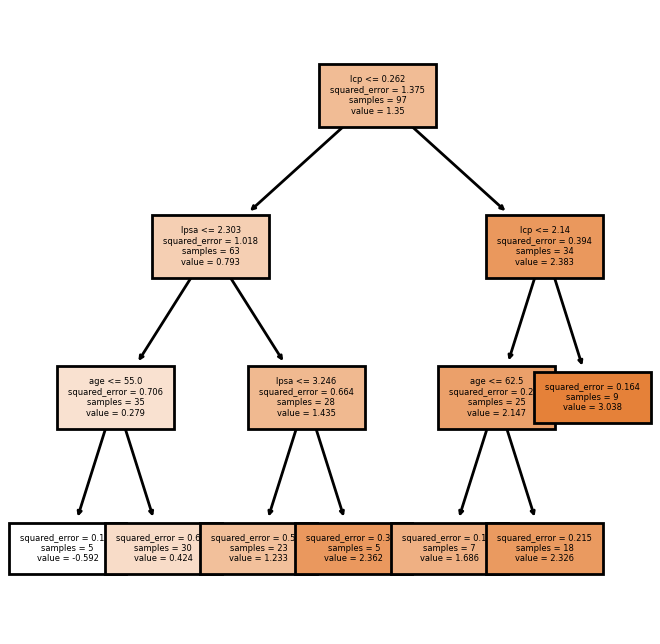

In [22]:
# we use above result of max_depth=3 for new tree 
cart = tree.DecisionTreeRegressor(criterion='squared_error', min_samples_split =7, min_samples_leaf = 5, max_depth = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X, y) #no split as small dataset

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 4), 'figure.dpi': 200})
tree.plot_tree(cart, feature_names = list(X.columns), filled = True,\
               fontsize = 3);

In [23]:
# the results are the same

In [24]:
# cross validation may not be the optimal method for pruning a tree
# Hence, we turn to bootstrap aggregating or bagging

*Idea: we obtain many trees by fitting CART on multiple with-replacement samples from our data. We then average over this bootstrapped sample of trees. The mean fit across bootstrap samples is an estimate of the average model fit.*  

*By averaging over multiple trees, we preserve the stable relationships that persist across bootstrap samples, while the noise averages out.*

<AxesSubplot:xlabel='time', ylabel='acceleration'>

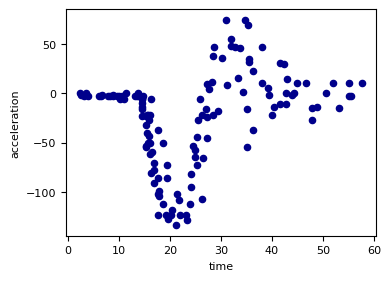

In [35]:
## Using a one-dimensional regression problem 

# https://github.com/TaddyLab/bayesian-forest/blob/master/data/mcycle.csv
# crash-test data of motorcycle helmets; acceleration after collision, 133 obs

df = pd.read_csv(r"C:\Users\johnd\OneDrive\Desktop\ML lecture\lecture6\data\mcycle.csv", delimiter = ';')
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})
df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue')

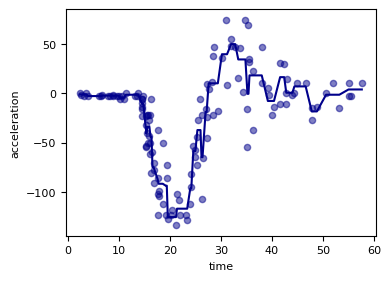

In [41]:
# fit a CART to the model
y = df['acceleration'] 
X = df['time'].values.reshape(-1,1)

cart = tree.DecisionTreeRegressor(min_samples_leaf = 3) # can experiment with parameters 
cart = cart.fit(X, y)

y_pred = cart.predict(X)

df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue', alpha = 0.5)
plt.plot(X, y_pred, c = 'DarkBlue')

In [42]:
# now, let's fit a random forest
# note, here we might need to add some stopping rule for our individual trees. Otherwise, random forest looks like it 
# overfits. 
# At the same time, your stopping rule should not be very strict. 
# In real applications always have a training and a test datasets, so that you could train different 
#  models and check their out-of-sample performance on the test data. 

y = df['acceleration'] 
X = df['time'].values.reshape(-1,1)

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1)
rf = rf.fit(X, y)

ypred_rf = rf.predict(X)

#you can see on the graph below that by growing full trees, our random forest estimator looks too noisy. (likely because we have a small number of observations)

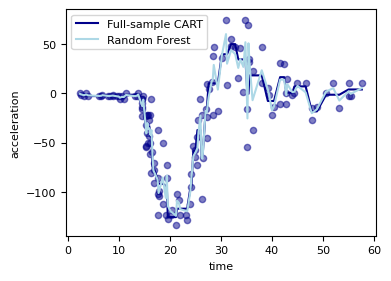

In [43]:
df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue', alpha = 0.5)
plt.plot(X, y_pred, c = 'DarkBlue', label = 'Full-sample CART')
plt.plot(X, ypred_rf, c = 'LightBlue', label="Random Forest")
plt.legend()

In [46]:
# Use cross-validation to determine the optimal number of trees
# I already added a stopping rule of min_samples_leaf = 3. 

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 3, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

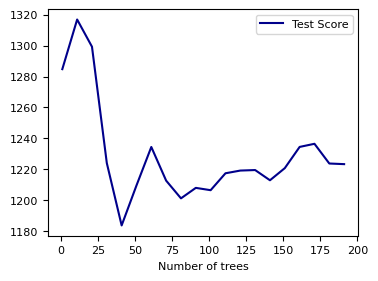

In [47]:
# note: it takes some time to run 
y = df['acceleration'] 
X = df['time'].values.reshape(-1,1)

result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X, y)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# On this graph we could also see how a random forest helps to reduce the MSE (our proxy for a single decision tree 
# is n_estimators = 1) 

In [48]:
results['Test Score'].idxmin()

41

In [49]:
rf = ensemble.RandomForestRegressor(n_estimators = 41, min_samples_leaf = 3, oob_score = True, \
        random_state = 1)
rf = rf.fit(X, y)

ypred_rf = rf.predict(X)


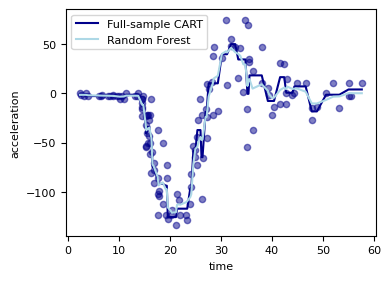

In [50]:
# we can see that now our random forest plot has relatively less noise, looks like it is not trying to overfit the data.
df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue', alpha = 0.5)
plt.plot(X, y_pred, c = 'DarkBlue', label = 'Full-sample CART')
plt.plot(X, ypred_rf, c = 'LightBlue', label="Random Forest")
plt.legend()

In [ ]:
# Matt Taddy (2019) Business Data Science: Combining Machine Learning and Economics to Optimize, Automate, and Accelerate Business Decisions. McGraw-Hill Education